In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime, timedelta
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, SeasonalNaive, Naive, SimpleExponentialSmoothingOptimized
import warnings
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import median_absolute_error as medae
from geopy.distance import geodesic

warnings.filterwarnings(
    "ignore",
    message="'force_all_finite' was renamed to 'ensure_all_finite'",
    category=FutureWarning,
    module="sklearn.utils.deprecation"
)
#Load the data
df=pd.read_csv('PEMS-BAY.csv',parse_dates=[0],index_col=[0])
#Filling the hour missing because of the time change
df_fill=df.reindex(pd.date_range('2017-03-12 02:00:00', '2017-03-12 03:00:00', freq='5min'),method='ffill')
df=df_fill.combine_first(df)
#Filling missing data
df.loc['2017-05-09 20:35:00']=(df.loc['2017-05-09 20:30:00']+df.loc['2017-05-09 20:40:00'])*0.5
df.loc['2017-05-05 19:55:00']=(df.loc['2017-05-05 19:50:00']+df.loc['2017-05-05 20:00:00'])*0.5
df.loc['2017-04-20 01:40:00']=(df.loc['2017-04-20 01:35:00']+df.loc['2017-04-20 01:45:00'])*0.5
#Load the test data
df_2022=pd.read_csv('PEMS-BAY_2022.csv',parse_dates=[0],index_col=[0])
df_2022.loc['2022-03-13 02:00:00':'2022-03-13 02:55:00']=df_2022.loc['2022-03-13 03:00:00'].values
#Reading meta data and computing the distance between sensors
meta=pd.read_csv('PEMS-BAY-META.csv')
total_sensor_num=len(meta)
dist=np.zeros([total_sensor_num,total_sensor_num])
for i in range(total_sensor_num):
    for j in range(i+1,total_sensor_num):
        dist[i][j]=geodesic((meta['Latitude'].iloc[i],meta['Longitude'].iloc[i]),(meta['Latitude'].iloc[j],meta['Longitude'].iloc[j])).kilometers
        dist[j][i]=dist[i][j]
df

400001  400017  400030  400040  400045  400052  400057  \
2017-01-01 00:00:00    71.4    67.8    70.5    67.4    68.8    66.6    66.8   
2017-01-01 00:05:00    71.6    67.5    70.6    67.5    68.7    66.6    66.8   
2017-01-01 00:10:00    71.6    67.6    70.2    67.4    68.7    66.1    66.8   
2017-01-01 00:15:00    71.1    67.5    70.3    68.0    68.5    66.7    66.6   
2017-01-01 00:20:00    71.7    67.8    70.2    68.1    68.4    66.9    66.1   
...                     ...     ...     ...     ...     ...     ...     ...   
2017-06-30 23:35:00    70.9    66.3    68.4    61.0    61.8    66.9    66.0   
2017-06-30 23:40:00    71.3    66.6    68.7    60.9    62.0    66.2    66.5   
2017-06-30 23:45:00    71.4    66.9    68.1    61.1    62.0    66.7    65.8   
2017-06-30 23:50:00    72.2    66.5    68.0    61.1    62.5    65.8    67.1   
2017-06-30 23:55:00    71.5    66.2    68.4    61.5    62.8    66.1    67.7   

                     400059  400065  400069  ...  409525  409526  409528  \
2017-01-01 00:00:00    68.0    66.8    69.0  ...    68.8    67.9    68.8   
2017-01-01 00:05:00    67.8    66.5    68.2  ...    68.4    67.3    68.4   
2017-01-01 00:10:00    67.8    66.2    67.8  ...    68.4    67.4    68.4   
2017-01-01 00:15:00    67.7    65.9    67.8  ...    68.5    67.5    68.5   
2017-01-01 00:20:00    67.7    66.1    67.8  ...    68.5    67.7    68.5   
...                     ...     ...     ...  ...     ...     ...     ...   
2017-06-30 23:35:00    67.4    65.4    69.3  ...    64.6    66.8    64.7   
2017-06-30 23:40:00    68.2    64.9    69.1  ...    65.1    67.3    64.8   
2017-06-30 23:45:00    68.2    64.2    69.1  ...    64.9    66.5    64.6   
2017-06-30 23:50:00    68.3    64.0    67.3  ...    64.1    65.9    64.8   
2017-06-30 23:55:00    68.4    64.9    68.0  ...    64.3    66.5    64.8   

                     409529  413026  413845  413877  413878  414284  414694  
2017-01-01 00:00:00    68.0    69.2    68.9    70.4    68.8    71.1    68.0  
2017-01-01 00:05:00    67.6    70.4    68.8    70.1    68.4    70.8    67.4  
2017-01-01 00:10:00    67.5    70.2    68.3    69.8    68.4    70.5    67.9  
2017-01-01 00:15:00    67.5    70.4    68.7    70.2    68.4    70.8    67.6  
2017-01-01 00:20:00    67.4    69.6    69.1    70.0    68.4    71.0    67.9  
...                     ...     ...     ...     ...     ...     ...     ...  
2017-06-30 23:35:00    61.1    68.4    61.4    70.5    68.2    71.6    66.2  
2017-06-30 23:40:00    60.8    69.8    62.2    69.4    68.6    71.6    68.4  
2017-06-30 23:45:00    61.3    69.5    63.8    70.6    68.4    71.6    66.6  
2017-06-30 23:50:00    61.3    69.6    64.2    70.2    68.7    71.6    68.4  
2017-06-30 23:55:00    60.9    70.9    63.4    70.3    68.7    71.6    68.0  

[52128 rows x 325 columns]

In [3]:
#Setting train/validation/test spit parameters
train_weeks_num=10
valid_weeks_num=3
weeks=train_weeks_num+valid_weeks_num
sensors_num=300
beginning=pd.to_datetime('2017-02-26 00:00:00')
df_all=df.loc[beginning:beginning+timedelta(weeks=weeks,minutes=-5)]
#Setting forecasting parameters
steps_num=18
pred_num=6048
ts=beginning+timedelta(weeks=train_weeks_num)
#Setting testing parameters
test_weeks_num=5
test_beginning=pd.to_datetime('2022-02-27 00:00:00')
test_pred_num=test_weeks_num*2016

In [6]:
#Making the df for seasonal differences and historical average
df_diff=df_all.diff(2016).dropna()
df_hist=df_all.copy()
for i in range(2016):
    avg=df_all.iloc[i:2016*train_weeks_num:2016].mean()
    for j in range(weeks):
        df_hist.iloc[i+j*2016]=avg
df_histdiff=df_all-df_hist
offset=10+steps_num
df_2022_diff=df_2022.diff(2016).dropna()
df_2022_all=df_2022.loc[test_beginning-timedelta(minutes=5*offset):test_beginning+timedelta(weeks=weeks,minutes=-5)]
df_2022_hist=df_hist.copy()
df_offset=pd.DataFrame(index=pd.date_range(end=df_2022_hist.index[0]-timedelta(minutes=5),periods=offset,freq='5min'),columns=df_2022_hist.columns)
for i in range(offset):
    df_offset.iloc[i]=df_2022_hist.iloc[2016+i-offset]
df_2022_hist=pd.concat([df_offset,df_2022_hist]).sort_index()
df_2022_hist.index = df_2022_all.index
df_2022_histdiff=df_2022_all-df_2022_hist

In [7]:
#Making df for train and validation
df_train_all=df_all.loc[beginning:beginning+timedelta(weeks=train_weeks_num,minutes=-5)]
df_valid_all=df_all.loc[beginning+timedelta(weeks=train_weeks_num):beginning+timedelta(weeks=train_weeks_num+valid_weeks_num,minutes=-5)]
df_train_all_diff=df_diff.loc[beginning:beginning+timedelta(weeks=train_weeks_num,minutes=-5)]
df_valid_all_diff=df_diff.loc[beginning+timedelta(weeks=train_weeks_num):beginning+timedelta(weeks=train_weeks_num+valid_weeks_num,minutes=-5)]
df_train_all_hist=df_hist.loc[beginning:beginning+timedelta(weeks=train_weeks_num,minutes=-5)]
df_valid_all_hist=df_hist.loc[beginning+timedelta(weeks=train_weeks_num):beginning+timedelta(weeks=train_weeks_num+valid_weeks_num,minutes=-5)]
df_train_all_histdiff=df_histdiff.loc[beginning:beginning+timedelta(weeks=train_weeks_num,minutes=-5)]
df_valid_all_histdiff=df_histdiff.loc[beginning+timedelta(weeks=train_weeks_num):beginning+timedelta(weeks=train_weeks_num+valid_weeks_num,minutes=-5)]
#Making df for test
df_test_all=df_2022.loc[test_beginning-timedelta(minutes=5*offset):test_beginning+timedelta(weeks=test_weeks_num,minutes=-5)]
df_test_all_diff=df_2022_diff.loc[test_beginning-timedelta(minutes=5*offset):test_beginning+timedelta(weeks=test_weeks_num,minutes=-5)]
df_test_all_hist=df_2022_hist.loc[test_beginning-timedelta(minutes=5*offset):test_beginning+timedelta(weeks=test_weeks_num,minutes=-5)]
df_test_all_histdiff=df_2022_histdiff.loc[test_beginning-timedelta(minutes=5*offset):test_beginning+timedelta(weeks=test_weeks_num,minutes=-5)]

In [ ]:
df_eda=df_train_all.copy()
df_eda['AvgSpeed']=df_eda.mean(axis=1)
df_eda['Time']=df_eda.index.time
df_eda['DayOfWeek']=df_eda.index.day_name()
grouped_avg = df_eda.groupby(['DayOfWeek', 'Time'])['AvgSpeed'].mean().reset_index()
grouped_avg['Time'] = grouped_avg['Time'].astype(str)
g=sns.relplot(
    data=grouped_avg,
    x='Time',
    y='AvgSpeed',
    col='DayOfWeek',
    kind='line',
    col_wrap=4,
    height=3
)
g.savefig('plot1.png')

In [7]:
#Computing the avrage speed of sensors by time and day of the week
avg_speed=[]
for k in range(total_sensor_num):
    row=[np.array([df_train_all[df.columns[k]].loc[beginning+timedelta(minutes=5*j,weeks=i)] for i in range(train_weeks_num)]).mean() for j in range(2016)]
    row.append(meta['Latitude'].iloc[k])
    row.append(meta['Longitude'].iloc[k])
    avg_speed.append(row)
cols=pd.date_range(beginning,beginning+timedelta(weeks=1,minutes=-5),freq='5min')
cols=cols.strftime("%A %H:%M").to_numpy()
cols=np.append(cols,['Latitude','Longitude'])
avg_speed=pd.DataFrame(avg_speed,columns=np.array(cols))
avg_speed['sensor_id']=df.columns
avg_speed_weekday=[]
for k in range(total_sensor_num):
    row=[np.array([avg_speed.iloc[k,j+i*288] for i in range(1,6)]).mean() for j in range(288)]
    row.append(meta['Latitude'].iloc[k])
    row.append(meta['Longitude'].iloc[k])
    avg_speed_weekday.append(row)
cols=pd.date_range(beginning,beginning+timedelta(days=1,minutes=-5),freq='5min')
cols=cols.strftime("%H:%M").to_numpy()
cols=np.append(cols,['Latitude','Longitude'])
avg_speed_weekday=pd.DataFrame(avg_speed_weekday,columns=np.array(cols))
avg_speed_weekday['sensor_id']=df.columns
avg_speed_weekend=[]
for k in range(total_sensor_num):
    row=[np.array([avg_speed.iloc[k,j+i*288] for i in [0,6]]).mean() for j in range(288)]
    row.append(meta['Latitude'].iloc[k])
    row.append(meta['Longitude'].iloc[k])
    avg_speed_weekend.append(row)
cols=pd.date_range(beginning,beginning+timedelta(days=1,minutes=-5),freq='5min')
cols=cols.strftime("%H:%M").to_numpy()
cols=np.append(cols,['Latitude','Longitude'])
avg_speed_weekend=pd.DataFrame(avg_speed_weekend,columns=np.array(cols))
avg_speed_weekend['sensor_id']=df.columns

In [8]:
#Making an animated map for average speed
avg_speed_long_weekday=avg_speed_weekday.melt(
    id_vars=['sensor_id','Latitude','Longitude'],
    value_vars=[c for c in avg_speed_weekday.columns if c not in ['sensor_id','Latitude','Longitude']],
    var_name='time_str',
    value_name='speed',
)
avg_speed_long_weekend=avg_speed_weekend.melt(
    id_vars=['sensor_id','Latitude','Longitude'],
    value_vars=[c for c in avg_speed_weekend.columns if c not in ['sensor_id','Latitude','Longitude']],
    var_name='time_str',
    value_name='speed',
)
fig = px.scatter_mapbox(
    avg_speed_long_weekday,
    lat="Latitude",
    lon="Longitude",
    color="speed",
    animation_frame="time_str",
    animation_group="sensor_id",
    color_continuous_scale=["red", "green"],
    hover_name="sensor_id",
    hover_data={"speed":":.2f", "Latitude":False, "Longitude":False},
    mapbox_style="open-street-map",
    zoom=11,
    height=750,
    range_color=[avg_speed_long_weekday["speed"].min(), avg_speed_long_weekday["speed"].max()],  # stable color scale
)
fig.update_traces(marker=dict(size=14))
fig.write_html("sensor_speed_animation_weekday.html", auto_play=False)
fig = px.scatter_mapbox(
    avg_speed_long_weekend,
    lat="Latitude",
    lon="Longitude",
    color="speed",
    animation_frame="time_str",
    animation_group="sensor_id",
    color_continuous_scale=["red", "green"],
    hover_name="sensor_id",
    hover_data={"speed":":.2f", "Latitude":False, "Longitude":False},
    mapbox_style="open-street-map",
    zoom=11,
    height=750,
    range_color=[avg_speed_long_weekend["speed"].min(), avg_speed_long_weekend["speed"].max()],  # stable color scale
)
fig.update_traces(marker=dict(size=14))
fig.write_html("sensor_speed_animation_weekend.html", auto_play=False)

In [8]:
#Selecting sensors for training, making corresponding dfs
bad_columns=['401495', '402288', '402289', '402368', '402369', '404554']
df_selected=df.drop(columns=bad_columns).sample(n=sensors_num,axis=1,random_state=42)
sensors=df_selected.columns
sensors_orders=df.columns.get_indexer(df_selected.columns)
df_train=df_train_all[sensors]
df_valid=df_valid_all[sensors]
df_total=df_all[sensors]
df_test=df_test_all[sensors]
df_train_diff=df_train_all_diff[sensors]
df_valid_diff=df_valid_all_diff[sensors]
df_test_diff=df_test_all_diff[sensors]
df_total_diff=df_diff[sensors]
df_train_hist=df_train_all_hist[sensors]
df_valid_hist=df_valid_all_hist[sensors]
df_total_hist=df_hist[sensors]
df_test_hist=df_test_all_hist[sensors]
df_train_histdiff=df_train_all_histdiff[sensors]
df_valid_histdiff=df_valid_all_histdiff[sensors]
df_total_histdiff=df_histdiff[sensors]
df_test_histdiff=df_test_all_histdiff[sensors]

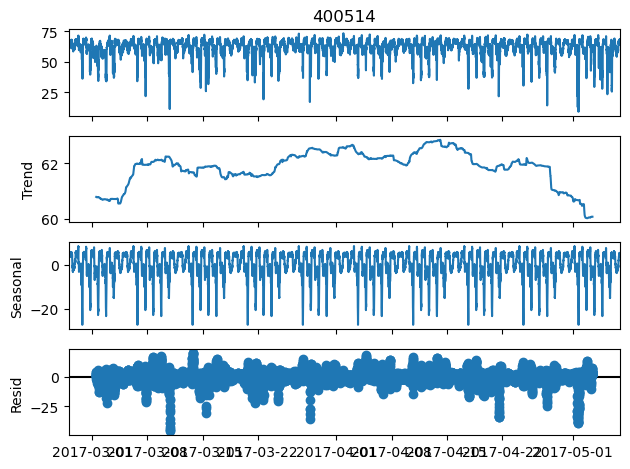

In [10]:
#Plotting the decomposition into seasonal, trend and residual parts
sensors_for_eda=[sensors[0]]
for sensor in sensors_for_eda:
    decomposed=seasonal_decompose(df_train[sensor], model = "add", period=2016)
    decomposed.plot()
    plt.rcParams['lines.linewidth'] = 0.75
    plt.show()

For original dataset:
ADF Statistic: -17.584518265268034
p-value: 3.992021440628235e-30
KPSS Statistic: 0.1250824753957612
p-value: 0.1
For differences:


C:\Users\Tom\AppData\Local\Temp\ipykernel_18848\2008735568.py:8: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




ADF Statistic: -19.521201913178242
p-value: 0.0
KPSS Statistic: 1.128659277039301
p-value: 0.01


C:\Users\Tom\AppData\Local\Temp\ipykernel_18848\2008735568.py:17: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




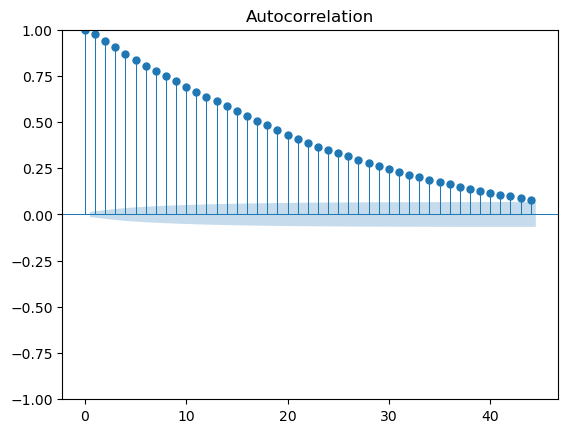

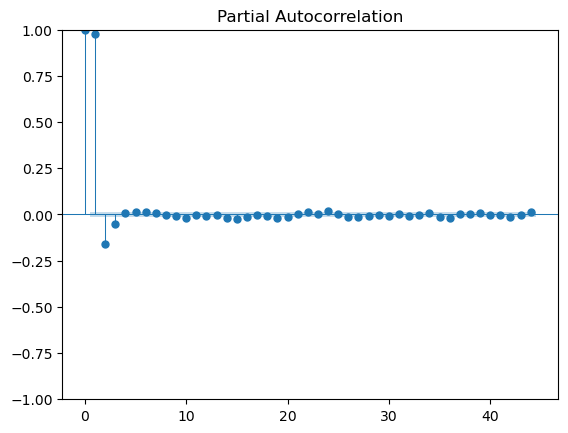

In [11]:
for sensor in sensors_for_eda:
    plot_acf(df_train[sensor])
    plot_pacf(df_train[sensor])
    print('For original dataset:')
    adf_result = adfuller(df_train[sensor])
    print('ADF Statistic:', adf_result[0])
    print('p-value:', adf_result[1])
    kpss_result = kpss(df_train[sensor])
    print('KPSS Statistic:', kpss_result[0])
    print('p-value:', kpss_result[1])

    print('For differences:')
    adf_result_diff = adfuller(df_train_diff[sensor])
    print('ADF Statistic:', adf_result_diff[0])
    print('p-value:', adf_result_diff[1])

    kpss_result_diff = kpss(df_train_diff[sensor])
    print('KPSS Statistic:', kpss_result_diff[0])
    print('p-value:', kpss_result_diff[1])

In [13]:
#Making functions to convert df from usual layout to the layout for StatsForecast
def sfdf(df):
    df_copy=df.copy()
    df_copy.index.name='ds'
    return df_copy.reset_index().melt(id_vars='ds',var_name='unique_id',value_name='y').sort_values(['unique_id','ds']).reset_index(drop=True)
def sfdfX(dff_all,dff_selected):
    df_all_shift=dff_all.shift(1).iloc[1:]
    selected_sensors=dff_selected.columns
    sensor=selected_sensors[0]
    sensor_ord=df.columns.get_indexer([sensor])[0]
    df_X=df_all_shift[neighbors[sensor_ord]].copy()
    df_X.columns=range(neighbors_num)
    df_X.insert(0, 'unique_id', sensor)
    df_X.insert(1, 'y', dff_selected[sensor].iloc[1:].values)
    df_X.index.name='ds'
    df_X=df_X.reset_index()
    for i in range(1,len(selected_sensors)):
        sensor=selected_sensors[i]
        sensor_ord=df.columns.get_indexer([sensor])[0]
        arr=df_all_shift[neighbors[sensor_ord]].copy()
        arr.columns=range(neighbors_num)
        arr.insert(0, 'unique_id', sensor)
        arr.insert(1, 'y', dff_selected[sensor].iloc[1:].values)
        arr.index.name='ds'
        arr=arr.reset_index()
        df_X=pd.concat([df_X,arr])
    #print(df_X.iloc[1:])
    return df_X

In [ ]:
#First group of models: training on the base dataset
sf1 = StatsForecast(
    models=[Naive(),AutoARIMA(),SimpleExponentialSmoothingOptimized()],
    freq='5min',
    n_jobs=-1
)

sf1.fit(sfdf(df_train))

In [ ]:
#Forecasting the first group
forecasts_naive=[]
for j in range(sensors_num):
    sensor=sensors[j]
    model=sf1.fitted_[j, 0]
    forecasts_one_sensor=np.zeros([pred_num,steps_num])
    for i in range(pred_num+steps_num):
        y_past=df_total[sensor].iloc[train_weeks_num*2016+i-steps_num-10:train_weeks_num*2016+i-steps_num].to_numpy()
        prediction=model.forward(y_past,steps_num)['mean']
        for step in range(steps_num):
            if (i+step>=steps_num) and (i+step<pred_num+steps_num):
                forecasts_one_sensor[i+step-steps_num][step]=prediction[step]
    forecasts_naive.append(forecasts_one_sensor)
    print(j+1,'sensors done')

In [ ]:
forecasts_arima=[]
for j in range(sensors_num):
    sensor=sensors[j]
    model=sf1.fitted_[j, 1]
    forecasts_one_sensor=np.zeros([pred_num,steps_num])
    for i in range(pred_num+steps_num):
        y_past=df_total[sensor].iloc[train_weeks_num*2016+i-steps_num-10:train_weeks_num*2016+i-steps_num].to_numpy()
        prediction=model.forward(y_past,steps_num)['mean']
        for step in range(steps_num):
            if (i+step>=steps_num) and (i+step<pred_num+steps_num):
                forecasts_one_sensor[i+step-steps_num][step]=prediction[step]
    forecasts_arima.append(forecasts_one_sensor)
    print(j+1,'sensors done')

In [ ]:
forecasts_seso=[]
for j in range(sensors_num):
    sensor=sensors[j]
    model=sf1.fitted_[j, 2]
    forecasts_one_sensor=np.zeros([pred_num,steps_num])
    for i in range(pred_num+steps_num):
        y_past=df_total[sensor].iloc[train_weeks_num*2016+i-steps_num-10:train_weeks_num*2016+i-steps_num].to_numpy()
        prediction=model.forecast(y_past,steps_num)['mean']
        for step in range(steps_num):
            if (i+step>=steps_num) and (i+step<pred_num+steps_num):
                forecasts_one_sensor[i+step-steps_num][step]=prediction[step]
    forecasts_seso.append(forecasts_one_sensor)
    print(j+1,'sensors done')

In [ ]:
#Second group of models: training on the seasonal difference dataset
sf2 = StatsForecast(
    models=[Naive(),AutoARIMA(),SimpleExponentialSmoothingOptimized()],
    freq='5min',
    n_jobs=-1
)

sf2.fit(sfdf(df_train_diff))

In [ ]:
#Forecasting the second group
forecasts_naive_sd=[]
for j in range(sensors_num):
    sensor=sensors[j]
    model=sf2.fitted_[j, 0]
    forecasts_one_sensor=np.zeros([pred_num,steps_num])
    for i in range(steps_num+pred_num):
        y_past=df_total_diff[sensor].iloc[train_weeks_num*2016+i-steps_num-10-2016:train_weeks_num*2016+i-steps_num-2016].to_numpy()
        prediction=model.forward(y_past,steps_num)['mean']
        for step in range(steps_num):
            if (i+step>=steps_num) and (i+step<pred_num+steps_num):
                past=df_total[sensor].loc[ts+timedelta(minutes=5*(i+step-steps_num-2016))]
                forecasts_one_sensor[i+step-steps_num][step]=prediction[step]+past
    forecasts_naive_sd.append(forecasts_one_sensor)
    print(j+1,'sensors done')

In [ ]:
forecasts_arima_sd=[]
for j in range(sensors_num):
    sensor=sensors[j]
    model=sf2.fitted_[j, 1]
    forecasts_one_sensor=np.zeros([pred_num,steps_num])
    for i in range(steps_num+pred_num):
        y_past=df_total_diff[sensor].iloc[train_weeks_num*2016+i-steps_num-7-2016:train_weeks_num*2016+i-steps_num-2016].to_numpy()
        prediction=model.forward(y_past,steps_num)['mean']
        for step in range(steps_num):
            if (i+step>=steps_num) and (i+step<pred_num+steps_num):
                past=df_total[sensor].loc[ts+timedelta(minutes=5*(i+step-steps_num-2016))]
                forecasts_one_sensor[i+step-steps_num][step]=prediction[step]+past
    forecasts_arima_sd.append(forecasts_one_sensor)
    print(j+1,'sensors done')

In [ ]:
forecasts_seso_sd=[]
for j in range(sensors_num):
    sensor=sensors[j]
    model=sf2.fitted_[j, 2]
    forecasts_one_sensor=np.zeros([pred_num,steps_num])
    for i in range(steps_num+pred_num):
        y_past=df_total_diff[sensor].iloc[train_weeks_num*2016+i-steps_num-10-2016:train_weeks_num*2016+i-steps_num-2016].to_numpy()
        prediction=model.forecast(y_past,steps_num)['mean']
        for step in range(steps_num):
            if (i+step>=steps_num) and (i+step<pred_num+steps_num):
                past=df_total[sensor].loc[ts+timedelta(minutes=5*(i+step-steps_num-2016))]
                forecasts_one_sensor[i+step-steps_num][step]=prediction[step]+past
    forecasts_seso_sd.append(forecasts_one_sensor)
    print(j+1,'sensors done')

In [ ]:
#Third group of models: training on the historical average dataset
sf3 = StatsForecast(
    models=[Naive(),AutoARIMA(),SimpleExponentialSmoothingOptimized()],
    freq='5min',
    n_jobs=-1
)

sf3.fit(sfdf(df_train_histdiff))

In [ ]:
#Forecasting the third group
forecasts_naive_h=[]
for j in range(sensors_num):
    sensor=sensors[j]
    model=sf3.fitted_[j, 0]
    forecasts_one_sensor=np.zeros([pred_num,steps_num])
    for i in range(pred_num+steps_num):
        y_past=df_total_histdiff[sensor].iloc[train_weeks_num*2016+i-steps_num-10:train_weeks_num*2016+i-steps_num].to_numpy()
        prediction=model.forward(y_past,steps_num)['mean']
        for step in range(steps_num):
            if (i+step>=steps_num) and (i+step<pred_num+steps_num):
                forecasts_one_sensor[i+step-steps_num][step]=prediction[step]+df_hist[sensor].iloc[train_weeks_num*2016+i+step-steps_num]
    forecasts_naive_h.append(forecasts_one_sensor)
    print(j+1,'sensors done')

In [ ]:
forecasts_arima_h=[]
for j in range(sensors_num):
    sensor=sensors[j]
    model=sf3.fitted_[j, 1]
    forecasts_one_sensor=np.zeros([pred_num,steps_num])
    for i in range(pred_num+steps_num):
        y_past=df_total_histdiff[sensor].iloc[train_weeks_num*2016+i-steps_num-7:train_weeks_num*2016+i-steps_num].to_numpy()
        prediction=model.forward(y_past,steps_num)['mean']
        for step in range(steps_num):
            if (i+step>=steps_num) and (i+step<pred_num+steps_num):
                forecasts_one_sensor[i+step-steps_num][step]=prediction[step]+df_hist[sensor].iloc[train_weeks_num*2016+i+step-steps_num]
    forecasts_arima_h.append(forecasts_one_sensor)
    print(j+1,'sensors done')

In [ ]:
forecasts_seso_h=[]
for j in range(sensors_num):
    sensor=sensors[j]
    model=sf3.fitted_[j, 2]
    forecasts_one_sensor=np.zeros([pred_num,steps_num])
    for i in range(pred_num+steps_num):
        y_past=df_total_histdiff[sensor].iloc[train_weeks_num*2016+i-steps_num-10:train_weeks_num*2016+i-steps_num].to_numpy()
        prediction=model.forecast(y_past,steps_num)['mean']
        for step in range(steps_num):
            if (i+step>=steps_num) and (i+step<pred_num+steps_num):
                forecasts_one_sensor[i+step-steps_num][step]=prediction[step]+df_hist[sensor].iloc[train_weeks_num*2016+i+step-steps_num]
    forecasts_seso_h.append(forecasts_one_sensor)
    print(j+1,'sensors done')

In [ ]:
#Forecasing using the historical average
forecasts_ha=[]
for j in range(sensors_num):
    sensor=sensors[j]
    forecasts_one_sensor=np.zeros([pred_num,steps_num])
    for i in range(pred_num+steps_num):
        for step in range(steps_num):
            if (i+step>=steps_num) and (i+step<pred_num+steps_num):
                forecasts_one_sensor[i+step-steps_num][step]=df_hist[sensor].iloc[train_weeks_num*2016+i+step-steps_num]
    forecasts_ha.append(forecasts_one_sensor)
    print(j+1,'sensors done')

In [ ]:
#Computing rmses
rmses=[]
all_forecasts=[forecasts_naive,forecasts_arima,forecasts_seso,forecasts_naive_sd,forecasts_arima_sd,forecasts_seso_sd,forecasts_naive_h,forecasts_arima_h,forecasts_seso_h,forecasts_ha]
#all_forecasts= np.load("all_forecasts.npy")
for j in range(sensors_num):
    rmses_one_sensor=[]
    actual=df_valid[sensors[j]].iloc[:pred_num]
    for step in range(steps_num):
        rmses_onestep=[]
        for forecast in all_forecasts:
            rmses_onestep.append(rmse(actual,forecast[j][:,step]))
        rmses_one_sensor.append(rmses_onestep)
    rmses.append(rmses_one_sensor)
rmses_total=[]
for step in range(steps_num):
    rmses_onestep=[]
    for i in range(len(all_forecasts)):
        rmses_onestep.append(np.array(rmses)[:,step,i].mean())
    rmses_total.append(rmses_onestep)
rmses.append(rmses_total)

In [ ]:
#Saving forecasts to a file
#X = np.stack([np.stack(group, axis=0) for group in all_forecasts], axis=0)
#np.save("all_forecasts.npy", X)

In [ ]:
titles=['Naive','ARIMA','SESO','Naive_sd','ARIMA_sd','SESO_sd','Naive_h','ARIMA_h','SESO_h','ARIMAX_h','HA']
#for j in range(sensors_num):
    #print('Sensor',j+1)
    #print(pd.DataFrame(rmses[j],columns=titles))
print('Total')
display(pd.DataFrame(rmses[sensors_num],columns=titles))

In [ ]:
#Plotting the average rmse of different models depending on the predicting time into the future
for i in range(len(titles)):
    plt.plot(5*np.arange(1,steps_num+1),np.array(rmses[-1])[:,i],label=titles[i])
plt.legend()
plt.savefig('plot2.png')

In [ ]:
weekdays=[day for day in range(valid_weeks_num*7) if day%7 not in [0,6]]
weekends=[day for day in range(valid_weeks_num*7) if day%7 in [0,6]]

In [152]:
#Finding the best model for each sensor and timestep
cols=avg_speed.columns
best_models=[]
for step in range(steps_num):
    rows=[]
    for sens in range(sensors_num):
        actual=df_valid[sensors[sens]].iloc[:pred_num]
        row={c:0 for c in cols}
        for time in range(2016):
            arr=[0 for model in range(len(titles))]
            for week in range(valid_weeks_num):  
                arr+=[abs(all_forecasts[model][sens][time+week*2016][step]-actual[time+week*2016]) for model in range(len(titles))]
            row[cols[time]]=titles[arr.index(min(arr))]
        row['Latitude']=meta['Latitude'].iloc[sensors_orders[sens]]
        row['Longitude']=meta['Longitude'].iloc[sensors_orders[sens]]
        rows.append(row)
    best_models.append(pd.DataFrame(rows))

C:\Users\Tom\AppData\Local\Temp\ipykernel_3292\498048427.py:12: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



KeyboardInterrupt: 

In [180]:
cols=avg_speed_weekday.columns
best_models_weekday=[]
for step in range(steps_num):
    rows=[]
    for sens in range(sensors_num):
        actual=df_valid[sensors[sens]].iloc[:pred_num]
        row={c:0 for c in cols}
        for time in range(288):
            arr=np.array([0.0 for model in range(len(titles))])
            for day in weekdays:
                arr+=np.array([abs(all_forecasts[model][sens][time+day*288][step]-actual[time+day*288]) for model in range(len(titles))])
            row[cols[time]]=titles[arr.argmin()]
        row['Latitude']=meta['Latitude'].iloc[sensors_orders[sens]]
        row['Longitude']=meta['Longitude'].iloc[sensors_orders[sens]]
        rows.append(row)
    best_models_weekday.append(pd.DataFrame(rows))
    best_models_weekday[step]['sensor_id']=sensors

C:\Users\Tom\AppData\Local\Temp\ipykernel_3292\376995270.py:11: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [181]:
cols=avg_speed_weekend.columns
best_models_weekend=[]
for step in range(steps_num):
    rows=[]
    for sens in range(sensors_num):
        actual=df_valid[sensors[sens]].iloc[:pred_num]
        row={c:0 for c in cols}
        for time in range(288):
            arr=[0 for model in range(len(titles))]
            for day in weekends:
                arr+=[abs(all_forecasts[model][sens][time+day*288][step]-actual[time+day*288]) for model in range(len(titles))]
            row[cols[time]]=titles[arr.index(min(arr))]
        row['Latitude']=meta['Latitude'].iloc[sensors_orders[sens]]
        row['Longitude']=meta['Longitude'].iloc[sensors_orders[sens]]
        rows.append(row)
    best_models_weekend.append(pd.DataFrame(rows))
    best_models_weekend[step]['sensor_id']=sensors

C:\Users\Tom\AppData\Local\Temp\ipykernel_3292\1444321140.py:11: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [182]:
#Displaying all best models
#with pd.option_context("display.max_rows", None, "display.max_columns", None):
#    display(best_models_weekday[0]) 

00:00     00:05     00:10     00:15     00:20     00:25     00:30  \
0          HA      SESO        HA      SESO        HA        HA      SESO   
1          HA   ARIMA_h        HA      SESO        HA        HA      SESO   
2          HA     Naive      SESO   Naive_h      SESO      SESO        HA   
3      SESO_h   Naive_h  ARIMA_sd      SESO   SESO_sd      SESO      SESO   
4        SESO    SESO_h      SESO   Naive_h      SESO     ARIMA     Naive   
5       Naive      SESO      SESO      SESO      SESO      SESO   ARIMA_h   
6    Naive_sd  Naive_sd  Naive_sd  Naive_sd  Naive_sd  Naive_sd  Naive_sd   
7      SESO_h      SESO      SESO     Naive      SESO    SESO_h    SESO_h   
8          HA    SESO_h      SESO     ARIMA     Naive     ARIMA      SESO   
9        SESO        HA    SESO_h  Naive_sd     Naive    SESO_h     Naive   
10         HA   Naive_h     ARIMA   SESO_sd     Naive      SESO    SESO_h   
11       SESO     Naive      SESO     Naive      SESO     Naive   Naive_h   
12      Naive  Naive_sd   SESO_sd  ARIMA_sd   SESO_sd  ARIMA_sd   SESO_sd   
13         HA      SESO      SESO        HA    SESO_h     ARIMA     ARIMA   
14         HA        HA      SESO        HA    SESO_h      SESO      SESO   
15         HA     Naive      SESO     ARIMA   Naive_h        HA        HA   
16      ARIMA   Naive_h     ARIMA      SESO     Naive     ARIMA     Naive   
17         HA     Naive        HA      SESO      SESO        HA   ARIMA_h   
18      Naive     Naive    SESO_h      SESO      SESO      SESO      SESO   
19         HA      SESO        HA     Naive        HA      SESO        HA   
20    SESO_sd   ARIMA_h     ARIMA     ARIMA     Naive      SESO     ARIMA   
21       SESO     ARIMA      SESO      SESO      SESO   ARIMA_h    SESO_h   
22         HA     Naive      SESO     ARIMA    SESO_h      SESO      SESO   
23         HA        HA      SESO        HA    SESO_h        HA        HA   
24         HA        HA   SESO_sd      SESO     Naive      SESO      SESO   
25         HA        HA      SESO    SESO_h    SESO_h        HA     ARIMA   
26       SESO     ARIMA     ARIMA      SESO      SESO        HA        HA   
27         HA    SESO_h     Naive    SESO_h      SESO    SESO_h        HA   
28     SESO_h     Naive        HA      SESO    SESO_h        HA        HA   
29         HA     ARIMA     ARIMA     ARIMA      SESO      SESO    SESO_h   
30         HA      SESO      SESO        HA      SESO   SESO_sd    SESO_h   
31         HA   Naive_h      SESO        HA    SESO_h     Naive        HA   
32         HA        HA    SESO_h    SESO_h   SESO_sd    SESO_h      SESO   
33       SESO    SESO_h   SESO_sd   SESO_sd    SESO_h      SESO        HA   
34         HA     ARIMA    SESO_h   Naive_h      SESO      SESO   Naive_h   
35         HA        HA        HA        HA   SESO_sd   SESO_sd        HA   
36         HA   Naive_h      SESO        HA        HA   SESO_sd   ARIMA_h   
37         HA      SESO        HA      SESO      SESO      SESO        HA   
38         HA     ARIMA   ARIMA_h      SESO     ARIMA        HA     ARIMA   
39      ARIMA     Naive     Naive    SESO_h      SESO        HA     Naive   
40       SESO      SESO        HA        HA      SESO      SESO    SESO_h   
41         HA     Naive     ARIMA      SESO      SESO      SESO     ARIMA   
42       SESO      SESO      SESO   SESO_sd    SESO_h      SESO      SESO   
43         HA     Naive      SESO      SESO        HA        HA        HA   
44         HA        HA        HA        HA        HA      SESO        HA   
45         HA     ARIMA      SESO        HA        HA     Naive        HA   
46         HA   Naive_h     Naive     Naive   SESO_sd     Naive     Naive   
47         HA      SESO        HA      SESO        HA    SESO_h    SESO_h   
48         HA    SESO_h     Naive     ARIMA    SESO_h     Naive    SESO_h   
49         HA     Naive     Naive     Naive   Naive_h      SESO        HA   
50         HA      SESO     Naive     Naive      SESO      SESO     Naive   
51  

In [176]:
#Making an animated map of the best model
step=0
best_models_weekday_long=best_models_weekday[step].melt(
    id_vars=['sensor_id','Latitude','Longitude'],
    value_vars=[c for c in best_models_weekday[step].columns if c not in ['sensor_id','Latitude','Longitude']],
    var_name='time_str',
    value_name='best_model',
)
color_map={
    'Naive':'#ffcccc',
    'ARIMA':'#ccffcc',
    'SESO':'#ccccff',
    'Naive_sd':'#ff0000',
    'ARIMA_sd':'#00ff00',
    'SESO_sd':'#0000ff',
    'Naive_h':'#cc0000',
    'ARIMA_h':'#00cc00',
    'SESO_h':'#0000cc',
    'ARIMA_hX':'#000000',
    'HA':'#777777',
}
fig = px.scatter_mapbox(
    best_models_weekday_long,
    lat="Latitude",
    lon="Longitude",
    color="best_model",
    animation_frame="time_str",
    animation_group="sensor_id",
    color_discrete_map=color_map,
    hover_name="sensor_id",
    hover_data={"best_model":":.2f", "Latitude":False, "Longitude":False},
    mapbox_style="open-street-map",
    zoom=11,
    height=750,
)
fig.update_traces(marker=dict(size=14))
fig.write_html("best_model_animation_weekday 5 min.html", auto_play=False)

In [ ]:
#Making an animated map of the best model
step=0
best_models_weekend_long=best_models_weekend[step].melt(
    id_vars=['sensor_id','Latitude','Longitude'],
    value_vars=[c for c in best_models_weekend[step].columns if c not in ['sensor_id','Latitude','Longitude']],
    var_name='time_str',
    value_name='best_model',
)
color_map={
    'Naive':'#ffcccc',
    'ARIMA':'#ccffcc',
    'SESO':'#ccccff',
    'Naive_sd':'#ff0000',
    'ARIMA_sd':'#00ff00',
    'SESO_sd':'#0000ff',
    'Naive_h':'#cc0000',
    'ARIMA_h':'#00cc00',
    'SESO_h':'#0000cc',
    'ARIMA_hX':'#000000',
    'HA':'#777777',
}
fig = px.scatter_mapbox(
    best_models_weekend_long,
    lat="Latitude",
    lon="Longitude",
    color="best_model",
    animation_frame="time_str",
    animation_group="sensor_id",
    color_discrete_map=color_map,
    hover_name="sensor_id",
    hover_data={"best_model":":.2f", "Latitude":False, "Longitude":False},
    mapbox_style="open-street-map",
    zoom=11,
    height=750,
)
fig.update_traces(marker=dict(size=14))
fig.write_html("best_model_animation_weekday.html", auto_play=False)

In [178]:
rows=[]
for sens in range(sensors_num):
    row={c:0 for c in range(5,61,5)}
    for step in range(steps_num):
        arr=rmses[sens][step]
        row[step*5+5]=titles[arr.index(min(arr))]
    row['Latitude']=meta['Latitude'].iloc[sensors_orders[sens]]
    row['Longitude']=meta['Longitude'].iloc[sensors_orders[sens]]
    row['sensor_id']=meta['Longitude'].iloc[sensors_orders[sens]]
    rows.append(row)
best_models_total=pd.DataFrame(rows)

In [179]:
#Making an animated map of the best model
best_models_total_long=best_models_total.melt(
    id_vars=['sensor_id','Latitude','Longitude'],
    value_vars=[c for c in best_models_total.columns if c not in ['sensor_id','Latitude','Longitude']],
    var_name='time_str',
    value_name='best_model',
)
color_map={
    'Naive':'#ffcccc',
    'ARIMA':'#ccffcc',
    'SESO':'#ccccff',
    'Naive_sd':'#ff0000',
    'ARIMA_sd':'#00ff00',
    'SESO_sd':'#0000ff',
    'Naive_h':'#cc0000',
    'ARIMA_h':'#00cc00',
    'SESO_h':'#0000cc',
    'ARIMA_hX':'#000000',
    'HA':'#777777',
}
fig = px.scatter_mapbox(
    best_models_total_long,
    lat="Latitude",
    lon="Longitude",
    color="best_model",
    animation_frame="time_str",
    animation_group="sensor_id",
    color_discrete_map=color_map,
    hover_name="sensor_id",
    hover_data={"best_model":":.2f", "Latitude":False, "Longitude":False},
    mapbox_style="open-street-map",
    zoom=11,
    height=750,
)
fig.update_traces(marker=dict(size=14))
fig.write_html("best_model_total.html", auto_play=False)

In [142]:
#Computing the average speed for all timeslots throughout the week
avgg=df_valid[sensors].mean(axis=1)
avgg_weekday=np.array([np.array([avgg.iloc[i+day*288] for day in weekdays]).mean() for i in range(288)])
avgg_weekend=np.array([np.array([avgg.iloc[i+day*288] for day in weekends]).mean() for i in range(288)])


difs=[]
for step in range(steps_num):
    difs_one_step=[]
    for i in range(len(titles)):
        difs_one_step.append(np.array([(df_valid[sensors[j]].iloc[:pred_num]-all_forecasts[i][j][:,step])**2 for j in range(sensors_num)]).mean(axis=0)**0.5)
    difs.append(difs_one_step)

weekday_timeslots=[[i+day*288 for day in weekdays] for i in range(288)]
weekend_timeslots=[[i+day*288 for day in weekends] for i in range(288)]
difs_weekday=[]
for step in range(steps_num):
    difs_one_step=[]
    for i in range(len(titles)):
        difs_one_step.append([np.array([(df_valid[sensors[j]].iloc[weekday_timeslots[k]]-all_forecasts[i][j][weekday_timeslots[k],step])**2 for j in range(sensors_num)]).mean()**0.5 for k in range(288)])
    difs_weekday.append(difs_one_step)




In [143]:
difs_weekend=[]
for step in range(steps_num):
    difs_one_step=[]
    for i in range(len(titles)):
        difs_one_step.append([np.array([(df_valid[sensors[j]].iloc[weekend_timeslots[k]]-all_forecasts[i][j][weekend_timeslots[k],step])**2 for j in range(sensors_num)]).mean()**0.5 for k in range(288)])
    difs_weekend.append(difs_one_step)

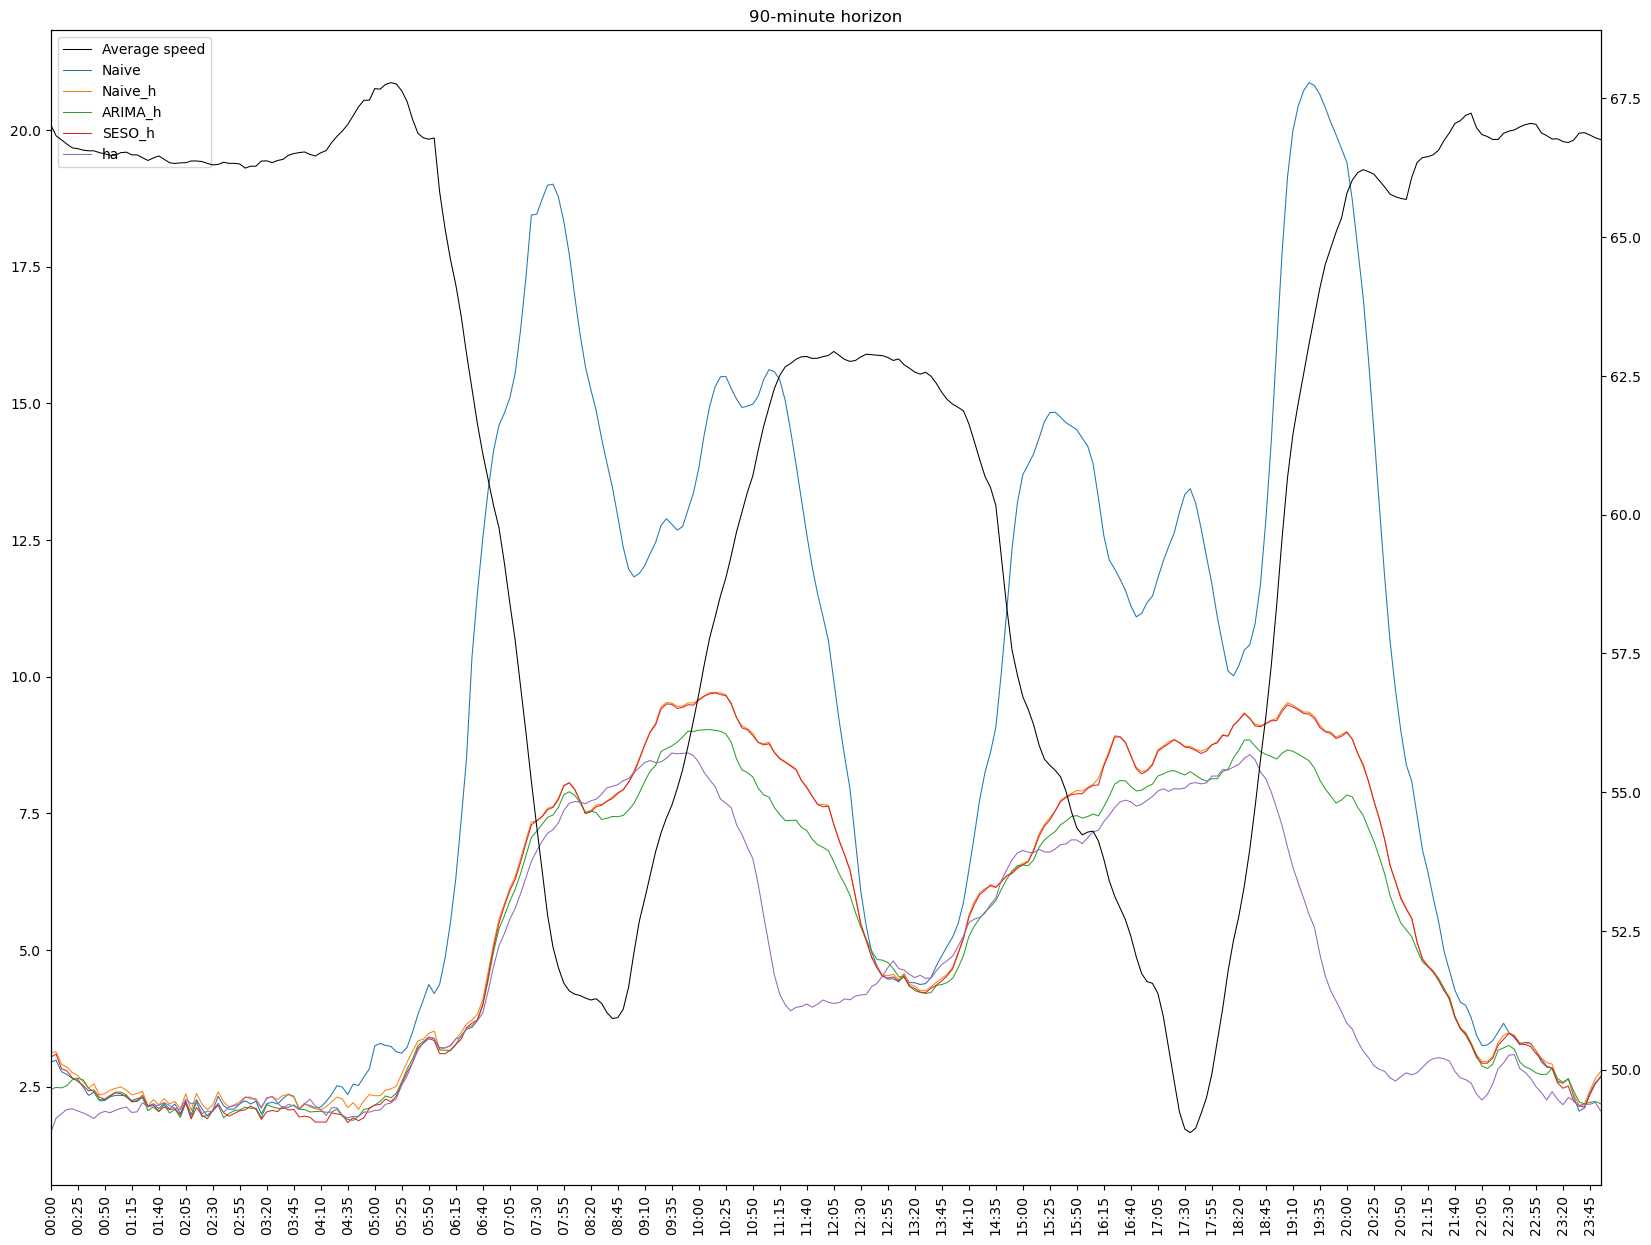

In [145]:
#Plotting the average rmse of models as a function of time during a day

def mm_to_hhmm(x, pos=None):
    h = int(x) // 60
    m = int(x) % 60
    return f"{h:02d}:{m:02d}"
fig, ax1 = plt.subplots(figsize=(20,15))
ax2=ax1.twinx()

ax1.set_xlim(0, 23*60 + 55)
ax1.xaxis.set_major_locator(mticker.MultipleLocator(25))
ax1.xaxis.set_major_formatter(mticker.FuncFormatter(mm_to_hhmm))
plt.setp(ax1.get_xticklabels(), rotation=90)
x_minutes = np.arange(0, 24 * 60, 5)
times = pd.date_range('2025-01-01 00:00', '2025-01-01 23:55', freq='5min')

ax1.set_title("90-minute horizon")
step=17

line1=ax1.plot(x_minutes,difs_weekday[step][0],label='Naive')
line2=ax1.plot(x_minutes,difs_weekday[step][6],label='Naive_h')
line3=ax1.plot(x_minutes,difs_weekday[step][7],label='ARIMA_h')
line4=ax1.plot(x_minutes,difs_weekday[step][8],label='SESO_h')
line5=ax1.plot(x_minutes,difs_weekday[step][9],label='ha')

line0=ax2.plot(x_minutes,avgg_weekday,label='Average speed',color='black')

lines=line0+line1+line2+line3+line4+line5
labels=[l.get_label() for l in lines]

ax1.legend(lines, labels, loc='upper left')

plt.savefig('plot3g.png')

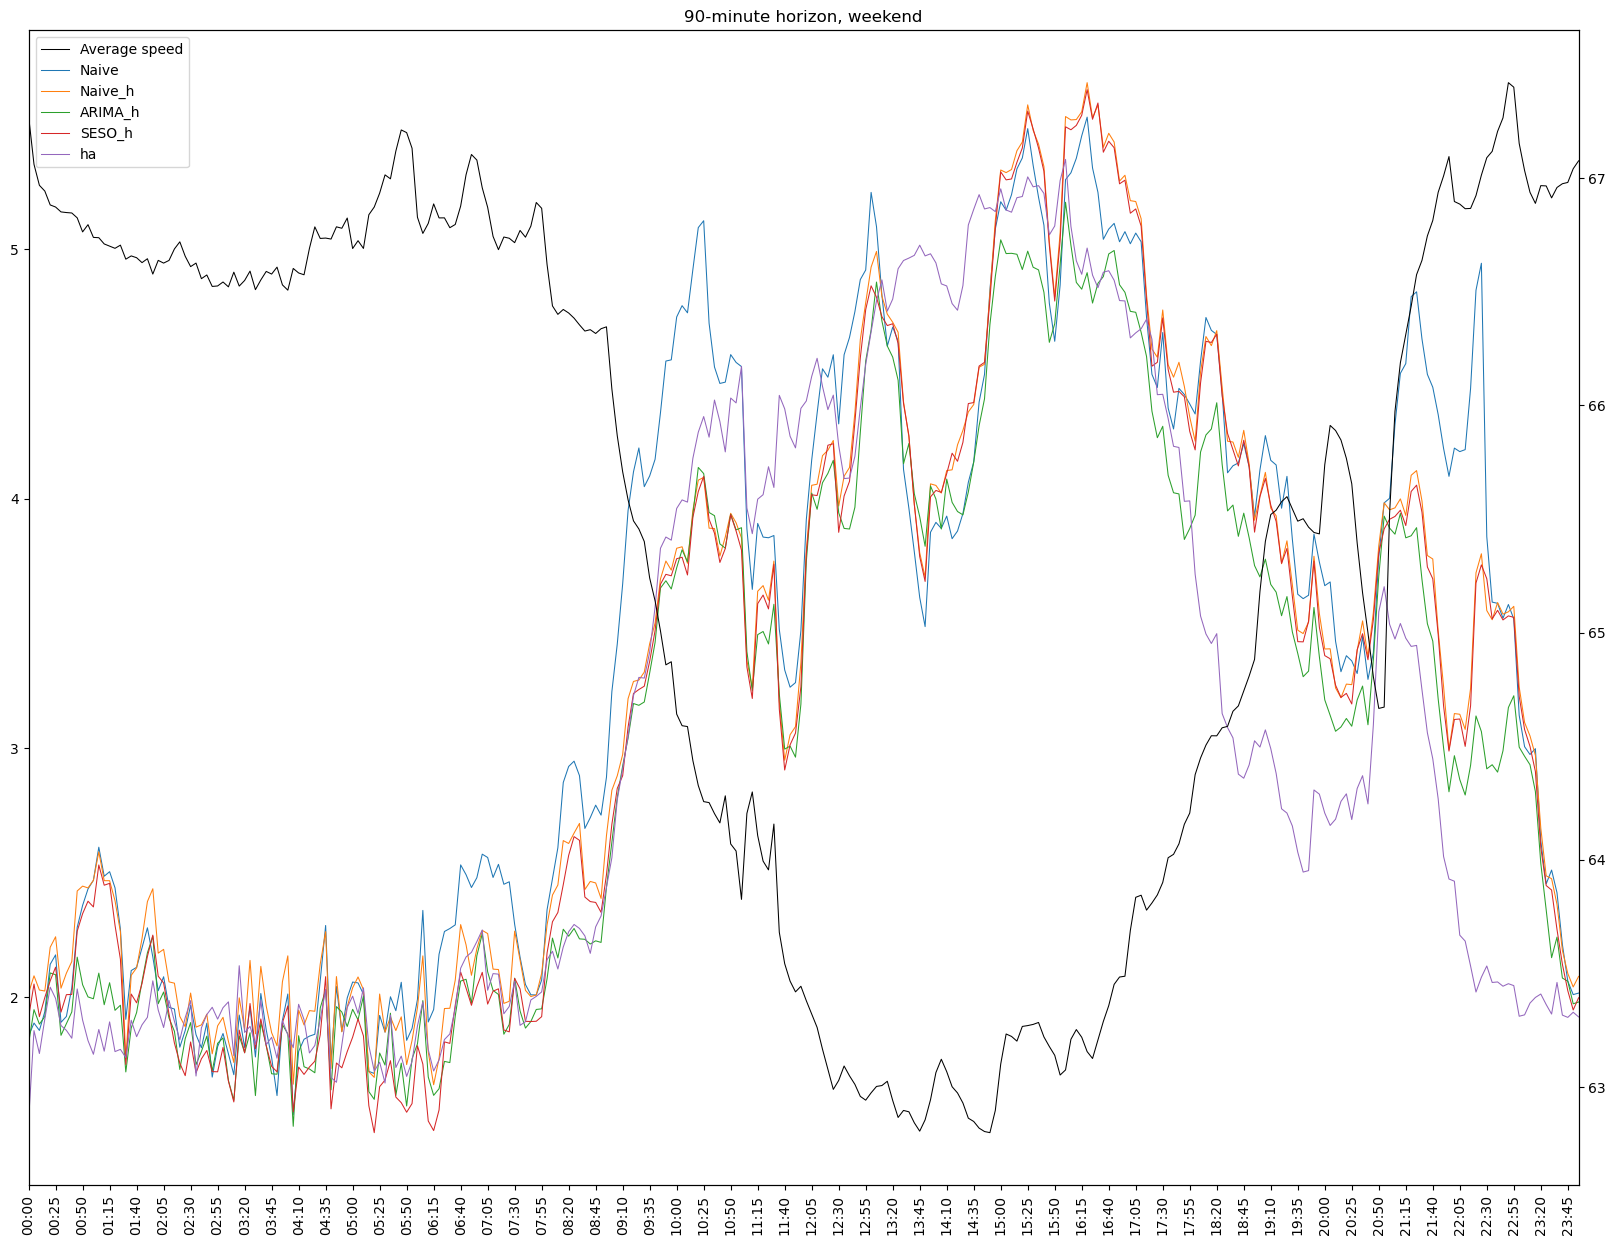

In [146]:
fig, ax1 = plt.subplots(figsize=(20,15))
ax2=ax1.twinx()

ax1.set_xlim(0, 23*60 + 55)
ax1.xaxis.set_major_locator(mticker.MultipleLocator(25))
ax1.xaxis.set_major_formatter(mticker.FuncFormatter(mm_to_hhmm))
plt.setp(ax1.get_xticklabels(), rotation=90)
x_minutes = np.arange(0, 24 * 60, 5)
times = pd.date_range('2025-01-01 00:00', '2025-01-01 23:55', freq='5min')

ax1.set_title("90-minute horizon, weekend")
step=17

line1=ax1.plot(x_minutes,difs_weekend[step][0],label='Naive')
line2=ax1.plot(x_minutes,difs_weekend[step][6],label='Naive_h')
line3=ax1.plot(x_minutes,difs_weekend[step][7],label='ARIMA_h')
line4=ax1.plot(x_minutes,difs_weekend[step][8],label='SESO_h')
line5=ax1.plot(x_minutes,difs_weekend[step][9],label='ha')

line0=ax2.plot(x_minutes,avgg_weekend,label='Average speed',color='black')

lines=line0+line1+line2+line3+line4+line5
labels=[l.get_label() for l in lines]

ax1.legend(lines, labels, loc='upper left')

plt.savefig('plot4g.png')

In [133]:
#Forecasting the first group for the test dataset
forecasts_naive_test=[]
for j in range(sensors_num):
    sensor=sensors[j]
    model=sf1.fitted_[j, 0]
    forecasts_one_sensor=np.zeros([test_pred_num,steps_num])
    for i in range(test_pred_num+steps_num):
        y_past=df_test[sensor].iloc[i:i+offset-steps_num].to_numpy()
        prediction=model.forward(y_past,steps_num)['mean']
        for step in range(steps_num):
            if (i+step>=steps_num) and (i+step<test_pred_num+steps_num):
                forecasts_one_sensor[i+step-steps_num][step]=prediction[step]
    forecasts_naive_test.append(forecasts_one_sensor)
    print(j+1,'sensors done')

1 sensors done
2 sensors done
3 sensors done
4 sensors done
5 sensors done
6 sensors done
7 sensors done
8 sensors done
9 sensors done
10 sensors done
11 sensors done
12 sensors done
13 sensors done
14 sensors done
15 sensors done
16 sensors done
17 sensors done
18 sensors done
19 sensors done
20 sensors done
21 sensors done
22 sensors done
23 sensors done
24 sensors done
25 sensors done
26 sensors done
27 sensors done
28 sensors done
29 sensors done
30 sensors done
31 sensors done
32 sensors done
33 sensors done
34 sensors done
35 sensors done
36 sensors done
37 sensors done
38 sensors done
39 sensors done
40 sensors done
41 sensors done
42 sensors done
43 sensors done
44 sensors done
45 sensors done
46 sensors done
47 sensors done
48 sensors done
49 sensors done
50 sensors done
51 sensors done
52 sensors done
53 sensors done
54 sensors done
55 sensors done
56 sensors done
57 sensors done
58 sensors done
59 sensors done
60 sensors done
61 sensors done
62 sensors done
63 sensors done
6

In [136]:
forecasts_arima_test=[]
for j in range(sensors_num):
    sensor=sensors[j]
    model=sf1.fitted_[j, 1]
    forecasts_one_sensor=np.zeros([test_pred_num,steps_num])
    for i in range(test_pred_num+steps_num):
        y_past=df_test[sensor].iloc[i:i+offset-steps_num].to_numpy()
        prediction=model.forward(y_past,steps_num)['mean']
        for step in range(steps_num):
            if (i+step>=steps_num) and (i+step<test_pred_num+steps_num):
                forecasts_one_sensor[i+step-steps_num][step]=prediction[step]
    forecasts_arima_test.append(forecasts_one_sensor)
    print(j+1,'sensors done')

1 sensors done
2 sensors done
3 sensors done
4 sensors done
5 sensors done
6 sensors done
7 sensors done
8 sensors done
9 sensors done
10 sensors done
11 sensors done
12 sensors done
13 sensors done
14 sensors done
15 sensors done
16 sensors done
17 sensors done
18 sensors done
19 sensors done
20 sensors done
21 sensors done
22 sensors done
23 sensors done
24 sensors done
25 sensors done
26 sensors done
27 sensors done
28 sensors done
29 sensors done
30 sensors done
31 sensors done
32 sensors done
33 sensors done
34 sensors done
35 sensors done
36 sensors done
37 sensors done
38 sensors done
39 sensors done
40 sensors done
41 sensors done
42 sensors done
43 sensors done
44 sensors done
45 sensors done
46 sensors done
47 sensors done
48 sensors done
49 sensors done
50 sensors done
51 sensors done
52 sensors done
53 sensors done
54 sensors done
55 sensors done
56 sensors done
57 sensors done
58 sensors done
59 sensors done
60 sensors done
61 sensors done
62 sensors done
63 sensors done
6

In [137]:
forecasts_seso_test=[]
for j in range(sensors_num):
    sensor=sensors[j]
    model=sf1.fitted_[j, 2]
    forecasts_one_sensor=np.zeros([test_pred_num,steps_num])
    for i in range(test_pred_num+steps_num):
        y_past=df_test[sensor].iloc[i:i+offset-steps_num].to_numpy()
        prediction=model.forecast(y_past,steps_num)['mean']
        for step in range(steps_num):
            if (i+step>=steps_num) and (i+step<test_pred_num+steps_num):
                forecasts_one_sensor[i+step-steps_num][step]=prediction[step]
    forecasts_seso_test.append(forecasts_one_sensor)
    print(j+1,'sensors done')

1 sensors done
2 sensors done
3 sensors done
4 sensors done
5 sensors done
6 sensors done
7 sensors done
8 sensors done
9 sensors done
10 sensors done
11 sensors done
12 sensors done
13 sensors done
14 sensors done
15 sensors done
16 sensors done
17 sensors done
18 sensors done
19 sensors done
20 sensors done
21 sensors done
22 sensors done
23 sensors done
24 sensors done
25 sensors done
26 sensors done
27 sensors done
28 sensors done
29 sensors done
30 sensors done
31 sensors done
32 sensors done
33 sensors done
34 sensors done
35 sensors done
36 sensors done
37 sensors done
38 sensors done
39 sensors done
40 sensors done
41 sensors done
42 sensors done
43 sensors done
44 sensors done
45 sensors done
46 sensors done
47 sensors done
48 sensors done
49 sensors done
50 sensors done
51 sensors done
52 sensors done
53 sensors done
54 sensors done
55 sensors done
56 sensors done
57 sensors done
58 sensors done
59 sensors done
60 sensors done
61 sensors done
62 sensors done
63 sensors done
6

In [138]:
#Forecasting the second group for the test dataset
forecasts_naive_sd_test=[]
for j in range(sensors_num):
    sensor=sensors[j]
    model=sf2.fitted_[j, 0]
    forecasts_one_sensor=np.zeros([test_pred_num,steps_num])
    for i in range(steps_num+test_pred_num):
        y_past=df_test_diff[sensor].iloc[i:i+offset-steps_num].to_numpy()
        prediction=model.forward(y_past,steps_num)['mean']
        for step in range(steps_num):
            if (i+step>=steps_num) and (i+step<test_pred_num+steps_num):
                past=df_2022[sensor].loc[test_beginning+timedelta(minutes=5*(i+offset+step-steps_num-2016))]
                forecasts_one_sensor[i+step-steps_num][step]=prediction[step]+past
    forecasts_naive_sd_test.append(forecasts_one_sensor)
    print(j+1,'sensors done')

1 sensors done
2 sensors done
3 sensors done
4 sensors done
5 sensors done
6 sensors done
7 sensors done
8 sensors done
9 sensors done
10 sensors done
11 sensors done
12 sensors done
13 sensors done
14 sensors done
15 sensors done
16 sensors done
17 sensors done
18 sensors done
19 sensors done
20 sensors done
21 sensors done
22 sensors done
23 sensors done
24 sensors done
25 sensors done
26 sensors done
27 sensors done
28 sensors done
29 sensors done
30 sensors done
31 sensors done
32 sensors done
33 sensors done
34 sensors done
35 sensors done
36 sensors done
37 sensors done
38 sensors done
39 sensors done
40 sensors done
41 sensors done
42 sensors done
43 sensors done
44 sensors done
45 sensors done
46 sensors done
47 sensors done
48 sensors done
49 sensors done
50 sensors done
51 sensors done
52 sensors done
53 sensors done
54 sensors done
55 sensors done
56 sensors done
57 sensors done
58 sensors done
59 sensors done
60 sensors done
61 sensors done
62 sensors done
63 sensors done
6

In [139]:
forecasts_arima_sd_test=[]
for j in range(sensors_num):
    sensor=sensors[j]
    model=sf2.fitted_[j, 1]
    forecasts_one_sensor=np.zeros([test_pred_num,steps_num])
    for i in range(steps_num+test_pred_num):
        y_past=df_test_diff[sensor].iloc[i:i+offset-steps_num].to_numpy()
        prediction=model.forward(y_past,steps_num)['mean']
        for step in range(steps_num):
            if (i+step>=steps_num) and (i+step<test_pred_num+steps_num):
                past=df_2022[sensor].loc[test_beginning+timedelta(minutes=5*(i+offset+step-steps_num-2016))]
                forecasts_one_sensor[i+step-steps_num][step]=prediction[step]+past
    forecasts_arima_sd_test.append(forecasts_one_sensor)
    print(j+1,'sensors done')

1 sensors done
2 sensors done
3 sensors done
4 sensors done
5 sensors done
6 sensors done
7 sensors done
8 sensors done
9 sensors done
10 sensors done
11 sensors done
12 sensors done
13 sensors done
14 sensors done
15 sensors done
16 sensors done
17 sensors done
18 sensors done
19 sensors done
20 sensors done
21 sensors done
22 sensors done
23 sensors done
24 sensors done
25 sensors done
26 sensors done
27 sensors done
28 sensors done
29 sensors done
30 sensors done
31 sensors done
32 sensors done
33 sensors done
34 sensors done
35 sensors done
36 sensors done
37 sensors done
38 sensors done
39 sensors done
40 sensors done
41 sensors done
42 sensors done
43 sensors done
44 sensors done
45 sensors done
46 sensors done
47 sensors done
48 sensors done
49 sensors done
50 sensors done
51 sensors done
52 sensors done
53 sensors done
54 sensors done
55 sensors done
56 sensors done
57 sensors done
58 sensors done
59 sensors done
60 sensors done
61 sensors done
62 sensors done
63 sensors done
6

In [140]:
forecasts_seso_sd_test=[]
for j in range(sensors_num):
    sensor=sensors[j]
    model=sf2.fitted_[j, 2]
    forecasts_one_sensor=np.zeros([test_pred_num,steps_num])
    for i in range(steps_num+test_pred_num):
        y_past=df_test_diff[sensor].iloc[i:i+offset-steps_num].to_numpy()
        prediction=model.forecast(y_past,steps_num)['mean']
        for step in range(steps_num):
            if (i+step>=steps_num) and (i+step<test_pred_num+steps_num):
                past=df_2022[sensor].loc[test_beginning+timedelta(minutes=5*(i+offset+step-steps_num-2016))]
                forecasts_one_sensor[i+step-steps_num][step]=prediction[step]+past
    forecasts_seso_sd_test.append(forecasts_one_sensor)
    print(j+1,'sensors done')

1 sensors done
2 sensors done
3 sensors done
4 sensors done
5 sensors done
6 sensors done
7 sensors done
8 sensors done
9 sensors done
10 sensors done
11 sensors done
12 sensors done
13 sensors done
14 sensors done
15 sensors done
16 sensors done
17 sensors done
18 sensors done
19 sensors done
20 sensors done
21 sensors done
22 sensors done
23 sensors done
24 sensors done
25 sensors done
26 sensors done
27 sensors done
28 sensors done
29 sensors done
30 sensors done
31 sensors done
32 sensors done
33 sensors done
34 sensors done
35 sensors done
36 sensors done
37 sensors done
38 sensors done
39 sensors done
40 sensors done
41 sensors done
42 sensors done
43 sensors done
44 sensors done
45 sensors done
46 sensors done
47 sensors done
48 sensors done
49 sensors done
50 sensors done
51 sensors done
52 sensors done
53 sensors done
54 sensors done
55 sensors done
56 sensors done
57 sensors done
58 sensors done
59 sensors done
60 sensors done
61 sensors done
62 sensors done
63 sensors done
6

In [141]:
#Forecasting the third group
forecasts_naive_h_test=[]
for j in range(sensors_num):
    sensor=sensors[j]
    model=sf3.fitted_[j, 0]
    forecasts_one_sensor=np.zeros([test_pred_num,steps_num])
    for i in range(test_pred_num+steps_num):
        y_past=df_test_histdiff[sensor].iloc[i:i+offset-steps_num].to_numpy()
        prediction=model.forward(y_past,steps_num)['mean']
        for step in range(steps_num):
            if (i+step>=steps_num) and (i+step<test_pred_num+steps_num):
                forecasts_one_sensor[i+step-steps_num][step]=prediction[step]+df_test_hist[sensor].iloc[i+offset+step-steps_num]
    forecasts_naive_h_test.append(forecasts_one_sensor)
    print(j+1,'sensors done')

1 sensors done
2 sensors done
3 sensors done
4 sensors done
5 sensors done
6 sensors done
7 sensors done
8 sensors done
9 sensors done
10 sensors done
11 sensors done
12 sensors done
13 sensors done
14 sensors done
15 sensors done
16 sensors done
17 sensors done
18 sensors done
19 sensors done
20 sensors done
21 sensors done
22 sensors done
23 sensors done
24 sensors done
25 sensors done
26 sensors done
27 sensors done
28 sensors done
29 sensors done
30 sensors done
31 sensors done
32 sensors done
33 sensors done
34 sensors done
35 sensors done
36 sensors done
37 sensors done
38 sensors done
39 sensors done
40 sensors done
41 sensors done
42 sensors done
43 sensors done
44 sensors done
45 sensors done
46 sensors done
47 sensors done
48 sensors done
49 sensors done
50 sensors done
51 sensors done
52 sensors done
53 sensors done
54 sensors done
55 sensors done
56 sensors done
57 sensors done
58 sensors done
59 sensors done
60 sensors done
61 sensors done
62 sensors done
63 sensors done
6

In [142]:
forecasts_arima_h_test=[]
for j in range(sensors_num):
    sensor=sensors[j]
    model=sf3.fitted_[j, 1]
    forecasts_one_sensor=np.zeros([test_pred_num,steps_num])
    for i in range(test_pred_num+steps_num):
        y_past=df_test_histdiff[sensor].iloc[i:i+offset-steps_num].to_numpy()
        prediction=model.forward(y_past,steps_num)['mean']
        for step in range(steps_num):
            if (i+step>=steps_num) and (i+step<test_pred_num+steps_num):
                forecasts_one_sensor[i+step-steps_num][step]=prediction[step]+df_test_hist[sensor].iloc[i+offset+step-steps_num]
    forecasts_arima_h_test.append(forecasts_one_sensor)
    print(j+1,'sensors done')

1 sensors done
2 sensors done
3 sensors done
4 sensors done
5 sensors done
6 sensors done
7 sensors done
8 sensors done
9 sensors done
10 sensors done
11 sensors done
12 sensors done
13 sensors done
14 sensors done
15 sensors done
16 sensors done
17 sensors done
18 sensors done
19 sensors done
20 sensors done
21 sensors done
22 sensors done
23 sensors done
24 sensors done
25 sensors done
26 sensors done
27 sensors done
28 sensors done
29 sensors done
30 sensors done
31 sensors done
32 sensors done
33 sensors done
34 sensors done
35 sensors done
36 sensors done
37 sensors done
38 sensors done
39 sensors done
40 sensors done
41 sensors done
42 sensors done
43 sensors done
44 sensors done
45 sensors done
46 sensors done
47 sensors done
48 sensors done
49 sensors done
50 sensors done
51 sensors done
52 sensors done
53 sensors done
54 sensors done
55 sensors done
56 sensors done
57 sensors done
58 sensors done
59 sensors done
60 sensors done
61 sensors done
62 sensors done
63 sensors done
6

In [143]:
forecasts_seso_h_test=[]
for j in range(sensors_num):
    sensor=sensors[j]
    model=sf3.fitted_[j, 2]
    forecasts_one_sensor=np.zeros([test_pred_num,steps_num])
    for i in range(test_pred_num+steps_num):
        y_past=df_test_histdiff[sensor].iloc[i:i+offset-steps_num].to_numpy()
        prediction=model.forecast(y_past,steps_num)['mean']
        for step in range(steps_num):
            if (i+step>=steps_num) and (i+step<test_pred_num+steps_num):
                forecasts_one_sensor[i+step-steps_num][step]=prediction[step]+df_test_hist[sensor].iloc[i+offset+step-steps_num]
    forecasts_seso_h_test.append(forecasts_one_sensor)
    print(j+1,'sensors done')

1 sensors done
2 sensors done
3 sensors done
4 sensors done
5 sensors done
6 sensors done
7 sensors done
8 sensors done
9 sensors done
10 sensors done
11 sensors done
12 sensors done
13 sensors done
14 sensors done
15 sensors done
16 sensors done
17 sensors done
18 sensors done
19 sensors done
20 sensors done
21 sensors done
22 sensors done
23 sensors done
24 sensors done
25 sensors done
26 sensors done
27 sensors done
28 sensors done
29 sensors done
30 sensors done
31 sensors done
32 sensors done
33 sensors done
34 sensors done
35 sensors done
36 sensors done
37 sensors done
38 sensors done
39 sensors done
40 sensors done
41 sensors done
42 sensors done
43 sensors done
44 sensors done
45 sensors done
46 sensors done
47 sensors done
48 sensors done
49 sensors done
50 sensors done
51 sensors done
52 sensors done
53 sensors done
54 sensors done
55 sensors done
56 sensors done
57 sensors done
58 sensors done
59 sensors done
60 sensors done
61 sensors done
62 sensors done
63 sensors done
6

In [144]:
#Forecasing using the historical average
forecasts_ha_test=[]
for j in range(sensors_num):
    sensor=sensors[j]
    forecasts_one_sensor=np.zeros([test_pred_num,steps_num])
    for i in range(test_pred_num+steps_num):
        for step in range(steps_num):
            if (i+step>=steps_num) and (i+step<test_pred_num+steps_num):
                forecasts_one_sensor[i+step-steps_num][step]=df_test_hist[sensor].iloc[i+offset+step-steps_num]
    forecasts_ha_test.append(forecasts_one_sensor)
    print(j+1,'sensors done')

1 sensors done
2 sensors done
3 sensors done
4 sensors done
5 sensors done
6 sensors done
7 sensors done
8 sensors done
9 sensors done
10 sensors done
11 sensors done
12 sensors done
13 sensors done
14 sensors done
15 sensors done
16 sensors done
17 sensors done
18 sensors done
19 sensors done
20 sensors done
21 sensors done
22 sensors done
23 sensors done
24 sensors done
25 sensors done
26 sensors done
27 sensors done
28 sensors done
29 sensors done
30 sensors done
31 sensors done
32 sensors done
33 sensors done
34 sensors done
35 sensors done
36 sensors done
37 sensors done
38 sensors done
39 sensors done
40 sensors done
41 sensors done
42 sensors done
43 sensors done
44 sensors done
45 sensors done
46 sensors done
47 sensors done
48 sensors done
49 sensors done
50 sensors done
51 sensors done
52 sensors done
53 sensors done
54 sensors done
55 sensors done
56 sensors done
57 sensors done
58 sensors done
59 sensors done
60 sensors done
61 sensors done
62 sensors done
63 sensors done
6

In [145]:
#Computing rmses
rmses_test=[]
all_forecasts_test=[forecasts_naive_test,forecasts_arima_test,forecasts_seso_test,forecasts_naive_sd_test,forecasts_arima_sd_test,forecasts_seso_sd_test,forecasts_naive_h_test,forecasts_arima_h_test,forecasts_seso_h_test,forecasts_ha_test]
#all_forecasts_test= np.load("all_forecasts_test.npy")
for j in range(sensors_num):
    rmses_one_sensor=[]
    actual=df_test[sensors[j]].iloc[offset:test_pred_num+offset]
    for step in range(steps_num):
        rmses_onestep=[]
        for forecast in all_forecasts_test:
            rmses_onestep.append(rmse(actual,forecast[j][:,step]))
        rmses_one_sensor.append(rmses_onestep)
    rmses_test.append(rmses_one_sensor)
rmses_total=[]
for step in range(steps_num):
    rmses_onestep=[]
    for i in range(len(all_forecasts_test)):
        rmses_onestep.append(np.array(rmses_test)[:,step,i].mean())
    rmses_total.append(rmses_onestep)
rmses_test.append(rmses_total)

In [148]:
#Saving forecasts to a file
#X = np.stack([np.stack(group, axis=0) for group in all_forecasts_test], axis=0)
#np.save("all_forecasts_test.npy", X)

In [146]:
titles=['Naive','ARIMA','SESO','Naive_sd','ARIMA_sd','SESO_sd','Naive_h','ARIMA_h','SESO_h','HA']
#for j in range(sensors_num):
    #print('Sensor',j+1)
    #print(pd.DataFrame(rmses_test[j],columns=titles))
print('Total')
display(pd.DataFrame(rmses_test[sensors_num],columns=titles))

Total


Naive     ARIMA      SESO  Naive_sd  ARIMA_sd   SESO_sd   Naive_h  \
0   1.350650  1.385654  1.366645  6.445768  6.435268  6.415310  1.490353   
1   1.964914  2.013470  1.959295  6.580334  6.527403  6.542914  2.195956   
2   2.444393  2.497813  2.430528  6.700426  6.617483  6.658993  2.758153   
3   2.835048  2.887310  2.817155  6.804609  6.674746  6.761025  3.224089   
4   3.161800  3.209695  3.141413  6.893304  6.723428  6.847535  3.618534   
5   3.441684  3.482801  3.420907  6.968222  6.757458  6.921174  3.958204   
6   3.688316  3.721552  3.667110  7.031886  6.788905  6.984180  4.257879   
7   3.909478  3.933963  3.887414  7.087441  6.820363  7.038837  4.526057   
8   4.109070  4.123491  4.086901  7.135313  6.850640  7.085440  4.768022   
9   4.292496  4.295251  4.270314  7.175891  6.876193  7.126524  4.989351   
10  4.463659  4.453265  4.442056  7.212917  6.901242  7.163299  5.193388   
11  4.627553  4.602016  4.606688  7.245768  6.923067  7.196496  5.383475   
12  4.785125  4.743132  4.764768  7.275429  6.943830  7.226415  5.560832   
13  4.937075  4.878176  4.916718  7.303457  6.963671  7.254109  5.726039   
14  5.081680  5.004935  5.061093  7.328589  6.981248  7.278953  5.879370   
15  5.218913  5.123673  5.198169  7.351899  6.997714  7.302366  6.021794   
16  5.349389  5.235177  5.328563  7.374931  7.013890  7.325262  6.154497   
17  5.473384  5.339782  5.452442  7.396479  7.028420  7.346757  6.277572   

     ARIMA_h    SESO_h        HA  
0   1.694595  1.519316  6.325178  
1   2.396381  2.201521  6.325178  
2   2.993695  2.755026  6.325178  
3   3.450459  3.215990  6.325178  
4   3.829675  3.607067  6.325178  
5   4.130534  3.945297  6.325178  
6   4.390170  4.243828  6.325178  
7   4.639581  4.511121  6.325178  
8   4.866342  4.752618  6.325178  
9   5.067634  4.973588  6.325178  
10  5.254968  5.177420  6.325178  
11  5.423370  5.367679  6.325178  
12  5.578210  5.544817  6.325178  
13  5.720128  5.709599  6.325178  
14  5.848498  5.862442  6.325178  
15  5.967316  6.004517  6.325178  
16  6.077388  6.136857  6.325178  
17  6.178116  6.259646  6.325178

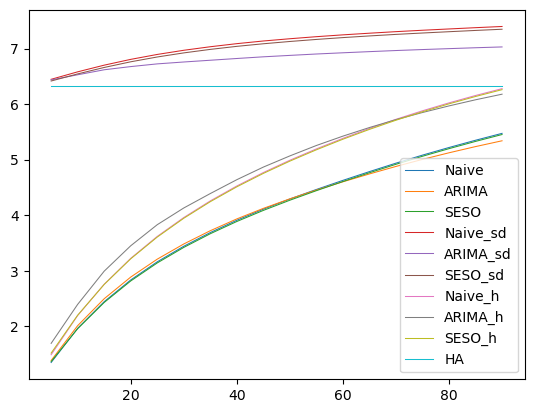

In [147]:
#Plotting the average rmse of different models depending on the predicting time into the future
for i in range(len(titles)):
    plt.plot(5*np.arange(1,steps_num+1),np.array(rmses_test[-1])[:,i],label=titles[i])
plt.legend()
plt.savefig('plot2test.png')

In [123]:
weekdays_test=[day for day in range(test_weeks_num*7) if day%7 not in [0,6]]
weekends_test=[day for day in range(test_weeks_num*7) if day%7 in [0,6]]

In [129]:
#Computing the average speed for all timeslots throughout the week
avgg_test=df_test[sensors].iloc[offset:].mean(axis=1)
avgg_weekday_test=np.array([np.array([avgg_test.iloc[i+day*288] for day in weekdays_test]).mean() for i in range(288)])
avgg_weekend_test=np.array([np.array([avgg_test.iloc[i+day*288] for day in weekends_test]).mean() for i in range(288)])


difs_test=[]
for step in range(steps_num):
    difs_one_step=[]
    for i in range(len(titles)):
        difs_one_step.append(np.array([(df_test[sensors[j]].iloc[offset:offset+pred_num]-all_forecasts_test[i][j][:,step])**2 for j in range(sensors_num)]).mean(axis=0)**0.5)
    difs_test.append(difs_one_step)

weekday_timeslots_test=[[i+day*288 for day in weekdays_test] for i in range(288)]
weekend_timeslots_test=[[i+day*288 for day in weekends_test] for i in range(288)]
weekday_timeslots_test_of=[[i+day*288+offset for day in weekdays_test] for i in range(288)]
weekend_timeslots_test_of=[[i+day*288+offset for day in weekends_test] for i in range(288)]
difs_weekday_test=[]
for step in range(steps_num):
    difs_one_step=[]
    for i in range(len(titles)):
        difs_one_step.append([np.array([(df_test[sensors[j]].iloc[weekday_timeslots_test_of[k]]-all_forecasts_test[i][j][weekday_timeslots_test[k],step])**2 for j in range(sensors_num)]).mean()**0.5 for k in range(288)])
    difs_weekday_test.append(difs_one_step)

difs_weekend_test=[]
for step in range(steps_num):
    difs_one_step=[]
    for i in range(len(titles)):
        difs_one_step.append([np.array([(df_test[sensors[j]].iloc[weekend_timeslots_test_of[k]]-all_forecasts_test[i][j][weekend_timeslots_test[k],step])**2 for j in range(sensors_num)]).mean()**0.5 for k in range(288)])
    difs_weekend_test.append(difs_one_step)


IndexError: index 6336 is out of bounds for axis 0 with size 6048

In [ ]:
#Plotting the average rmse of models as a function of time during a day

def mm_to_hhmm(x, pos=None):
    h = int(x) // 60
    m = int(x) % 60
    return f"{h:02d}:{m:02d}"
fig, ax1 = plt.subplots(figsize=(20,15))
ax2=ax1.twinx()

ax1.set_xlim(0, 23*60 + 55)
ax1.xaxis.set_major_locator(mticker.MultipleLocator(25))
ax1.xaxis.set_major_formatter(mticker.FuncFormatter(mm_to_hhmm))
plt.setp(ax1.get_xticklabels(), rotation=90)
x_minutes = np.arange(0, 24 * 60, 5)
times = pd.date_range('2025-01-01 00:00', '2025-01-01 23:55', freq='5min')

ax1.set_title("90-minute horizon")
step=17

line1=ax1.plot(x_minutes,difs_weekday_test[step][0],label='Naive')
line2=ax1.plot(x_minutes,difs_weekday_test[step][6],label='Naive_h')
line3=ax1.plot(x_minutes,difs_weekday_test[step][7],label='ARIMA_h')
line4=ax1.plot(x_minutes,difs_weekday_test[step][8],label='SESO_h')
line5=ax1.plot(x_minutes,difs_weekday_test[step][9],label='ha')

line0=ax2.plot(x_minutes,avgg_weekday,label='Average speed',color='black')

lines=line0+line1+line2+line3+line4+line5
labels=[l.get_label() for l in lines]

ax1.legend(lines, labels, loc='upper left')

plt.savefig('plot5g.png')